# Introduction
------------------------
In this notebook we'll play around with a pre-trained word model to look at its vocabulary and to try out some of the basic operations commonly performed on word vectors.

We'll start by using the Python package `gensim` which implements all of the basic features we need like loading the model, accessing its vocabulary, and performing similarity lookups. Immediately after, though, we'll go "under the covers" and perform the same operations manually so you can see what's really going on. 

# Contents
------------------

* [Inspecting the Model](#inspect_model) 
    * [Model Vocabulary](#model_vocab)
    * [Sample Vector](#sample_vector)
* [Word Similarities with gensim](#word_sim_gensim)
    * [Compare Two Words](#compare_two_gensim)
    * [Find Most Similar](#find_sim_gensim)
* [Word Similarities from Scratch](#word_sim_scratch)
    * [Word-pair Similarity from Scratch](#word_pair_scratch)
    * [Word Similarity Search from Scratch](#word_search_scratch)


# Inspecting the Model <a name="inspect_model"></a>
-------------------------------------
Along with the original word2vec papers, the authors [released](https://code.google.com/archive/p/word2vec/ "Homepage for Google's Word2Vec code and pre-trained models") a large Word2Vec model that they trained on roughly 100 billion words from a Google News dataset. It contains exactly 3 million words, and the word vectors have 300 features each. There are newer, presumably better, pre-trained models, but this is the original. 

Download the model file [here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing) (it's 3.39GB) and save it into a subdirectory: `./data/GoogleNews-vectors-negative300.bin` 

Once you've downloaded the model file, we'll use a helper function from `gensim` to load it as a `KeyedVector` class that provides a lot of convenience functions.

In [1]:
import gensim

filepath = './data/GoogleNews-vectors-negative300.bin'

# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format(filepath, binary=True)

## Model Vocabulary<a name="model_vocab"></a>
I usually start by poking around the vocabulary of the model to get a feel for it. Let's print some random vocab words in three columns.

In [2]:
import random

# Retrieve the list of words in the vocabulary as 'vocab'
vocab = list(model.vocab.keys())

# Print 20 random words in two columns.
for i in range(10):
    # Choose and print two random words
    print('%30s %30s' % (random.choice(vocab),
                         random.choice(vocab)))

                 GoldDerby.com        frisky_flappers_dashing
                          IAAO                   CardWizard_®
                     Carlander                        ELKADER
           sodium_metal_halide                        Olimpio
                   Wolf_Cesman                          Inc.Â
                     boondocks                         Sattui
                CEREUS_Network              Kettle_Merger_Sub
             HUMBERSIDE_Police                       Talgarth
      unstatesmanlike_behavior                       Al_Nabat
               Unsecured_Loans              shirts_emblazoned


---
Certainly a lot of non-sense in there! I've found this to be fairly typical of pre-trained word models. 

Let's look more explicitly at some different word types.

I'm going to define a little helper function which takes lists of words and then reports which are found, checking both lower and upper case.

In [3]:
def check_vocab(vocab, try_words):
    print("%30s    %s" % ('Word', 'Included'))    
    print("%30s    %s" % ('====', '========'))    
    
    for word in try_words:
        print("%30s    %s" % (word, str(word in model.vocab)))
        # If the word isn't already lower case, try lower case as well.
        if not word.lower() == word:
            print("%30s    %s" % (word.lower(), str(word.lower() in model.vocab)))


**Stop words**

In [4]:
check_vocab(vocab, ['a', 'and', 'the'])

                          Word    Included
                          ====    ========
                             a    False
                           and    False
                           the    True


**Multi-word names**

In [5]:
check_vocab(vocab, ['Abraham_Lincoln',
                    'Michael_Jordan',
                    'Tom_Brady',
                    'Elon_Musk',
                    'United_States',
                    'United_States_of_America',
                    ])

                          Word    Included
                          ====    ========
               Abraham_Lincoln    True
               abraham_lincoln    False
                Michael_Jordan    False
                michael_jordan    True
                     Tom_Brady    True
                     tom_brady    True
                     Elon_Musk    True
                     elon_musk    False
                 United_States    True
                 united_states    False
      United_States_of_America    False
      united_states_of_america    False


**Multi-word topics**

In [6]:
check_vocab(vocab, ['Computer_Science',
                    'Global_Warming',
                    'Foreign_Policy',
                    ])

                          Word    Included
                          ====    ========
              Computer_Science    True
              computer_science    False
                Global_Warming    True
                global_warming    True
                Foreign_Policy    False
                foreign_policy    False


**Idioms**

In [7]:
check_vocab(vocab, ['couch_potato',
                    'dime_a_dozen',
                    'hit_the_sack',
                    'cut_corners',
                    ])
    

                          Word    Included
                          ====    ========
                  couch_potato    True
                  dime_a_dozen    False
                  hit_the_sack    False
                   cut_corners    False


**Misspellings** (these are all misspelled)

In [8]:
check_vocab(vocab, ['accomodate',
                    'begining',
                    'concious',
                    'incidently',
                    'recomendations',
                    ])

                          Word    Included
                          ====    ========
                    accomodate    True
                      begining    True
                      concious    True
                    incidently    True
                recomendations    True


**Punctuation**

In [9]:
check_vocab(vocab, ['man`s',
                    'man\'s',
                    'it`s',
                    'it\'s',
                    'U.S.A.',
                    ])

                          Word    Included
                          ====    ========
                         man`s    False
                         man's    True
                          it`s    False
                          it's    True
                        U.S.A.    True
                        u.s.a.    False


**Numbers**

In [10]:
check_vocab(vocab, ['1',
                    'one',
                    '12',
                    'twelve',
                    '100',
                    'one_hundred',
                    ])

                          Word    Included
                          ====    ========
                             1    True
                           one    True
                            12    False
                        twelve    True
                           100    False
                   one_hundred    False


## Sample Vector <a name="sample_vector"></a>

Let's take a look inside a single vector, for the word "couch". 

From the output we can see that the values appear to range within -1.0 to 1.0, and that the vector is dense rather than sparse (no features are zero).

Vector shape: (300,)
Sample values:  <0.2285, -0.2949, 0.0006, ..., 0.0854, -0.0018>
Norm: 3.13
Number of zeros: 0 of 300


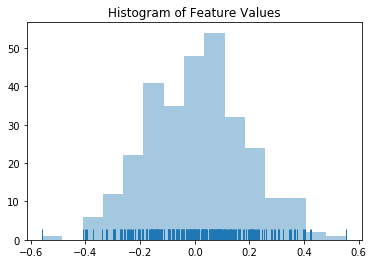

In [11]:
%matplotlib inline
import seaborn as sns
import numpy as np

# Let's peek at the word vector for the word 'couch'.
vec = model.word_vec('couch')

# Shape and sample values:
print("Vector shape: " + str(vec.shape))
print("Sample values:  <%.4f, %.4f, %.4f, ..., %.4f, %.4f>" % 
      (vec[0], vec[1], vec[2], vec[-2], vec[-1]))

# What's the vector's magnitude?
print("Norm: %.2f" % np.linalg.norm(vec))

# Are some values zero? How many?
num_zero = len(vec) - np.count_nonzero(vec)
print("Number of zeros: %d of %d" % (num_zero, len(vec)))

# Plot a histogram of the feature values to visualize their
# distribution.
ax = sns.distplot(vec, kde=False, rug=True)
t = ax.set_title('Histogram of Feature Values')

# Word Similarities with gensim <a name="word_sim_gensim"></a>
----------------------------------------------
`gensim` includes convenience functions for computing a number of common word similarity operations.

## Compare Two Words<a name="compare_two_gensim"></a>
--------------------------------
The `model` object has convenience functions for comparing two vectors. The below code shows that "couch" and "book" have a low similarity, while "couch" and "sofa" are very similar--as we would hope.

In [12]:
# Let's try comparing some specific words.
# First, how similar are "couch" and "book"?
score = model.similarity('couch', 'book')
print("Cosine similarity between 'couch' and 'book' is %.2f" % score)

# How about "couch" and "sofa"?
score = model.similarity('couch', 'sofa')
print("Cosine similarity between 'couch' and 'sofa' is %.2f\n" % score)

Cosine similarity between 'couch' and 'book' is 0.12
Cosine similarity between 'couch' and 'sofa' is 0.83



## Find Most Similar<a name="find_sim_gensim"></a>
----------------------------
We can also find the most similar words in the vocabulary to "couch". 

The results look pretty sensible!

In [13]:
# What are the 10 most similar words to "couch" in the vocabulary?
results = model.most_similar(positive='couch', topn=10)

# Print out the results.
print("10 most similar words to 'couch':")
print("%20s    %s" % ('word', 'score'))
for (word, score) in results:
    print("%20s    %.2f" % (word, score))

10 most similar words to 'couch':
                word    score
                sofa    0.83
            recliner    0.74
             couches    0.70
         comfy_couch    0.67
               futon    0.65
    al_Jabouri_slept    0.62
            loveseat    0.62
       beanbag_chair    0.62
      recliner_chair    0.61
              settee    0.61


Fun side note: What's with the "al Jabouri slept" result? I believe this is an artifact of the Google News dataset. This particular phrase comes from [this story](https://www.mercurynews.com/2010/12/29/three-suicide-bombers-used-to-kill-tenacious-iraqi-cop/) which mentions an officer named al-Jabouri sleeping on a couch! 
A problem with this Google News dataset is that news outlets all over will take articles (from Reuters, I think?) and just modify them slightly, so there are many near-duplicate news articles out there. 

# Word Similarity from Scratch<a name="word_sim_scratch"></a>
--------------------------------------
It's great that gensim makes these operations easy for us, but to make sure we have a firm grasp on how they work, let's implement the above vector operations from scratch--just for educational purposes.

(Side Note: If you want to keep playing with gensim a little more, there's nice documentation for the KeyedVectors class [here](https://radimrehurek.com/gensim/models/keyedvectors.html)).

Let's start by pulling the word vectors matrix out of the model.

In [14]:
# Note - Older versions of gensim stored the vectors in `model.syn0` 
vecs = model.vectors

print('Word vector matrix is: ' + str(vecs.shape))

Word vector matrix is: (3000000, 300)


## Word-pair Similarity from Scratch<a name="word_pair_scratch"></a>
--------------------------
Now let's pull out our specific word vectors manually by looking up their index from the vocabulary.

In [15]:
import numpy as np

# Let's look up the index of the vector for 'couch' and 'sofa'.
w1 = model.vocab['couch'].index
w2 = model.vocab['sofa'].index

# Select the vectors using their row index.
v1 = vecs[w1, :]
v2 = vecs[w2, :]

# Let's check out the norms of these two vectors.
print('Norm for "couch": %.2f' % np.linalg.norm(v1))
print('Norm for "sofa": %.2f' % np.linalg.norm(v2))


Norm for "couch": 3.13
Norm for "sofa": 3.16


----------------
Here's the formula for the cosine similarity of two vectors 'x' and 'y'. 

$ cos(\pmb x, \pmb y) = \frac {\pmb x \cdot \pmb y}{||\pmb x|| \cdot ||\pmb y||} $

The formula is written as the dot-product of the vectors, divided by the product of their magnitudes. However, we can change the order and normalize the vectors first, then take their dot products. It's better to think of it in this order--we'll see why in a bit.

In [16]:
# Normalize our vectors:
v1_norm = v1 / np.linalg.norm(v1)
v2_norm = v2 / np.linalg.norm(v2)

# Let's double check the result:
print('New norm of "couch": %.2f' % np.linalg.norm(v1_norm))
print('New norm of "sofa": %.2f' % np.linalg.norm(v2_norm))

# Now we can take the dot-product of the normalized vectors:
cos_sim = np.dot(v1_norm, v2_norm)

print('\nCosine similarity between "couch" and "sofa": %.2f' % cos_sim)

# Also show the gensim results as a sanity-check
print('    (gensim: %.2f)' % model.similarity('couch', 'sofa'))

New norm of "couch": 1.00
New norm of "sofa": 1.00

Cosine similarity between "couch" and "sofa": 0.83
    (gensim: 0.83)


## Word Similarity Search from Scratch<a name="word_search_scratch"></a>
----------------------------
Now let's try searching the vocabulary for the top-10 most similar words to "couch".

We could iterate over all 3M words in the vocabulary, calculating the cosine similarity as we did above, and then sorting them. This is brutally slow, though! As you may know, it's much more efficient to perform vector-matrix operations. We'll multiply the vector against the whole matrix, and the processor will be able to use efficient linear algebra routines and SIMD instructions to speed up this heavy compute task.

Here is where it's going to help us to change up the order of operations. If we simply normalize the entire word vector matrix as pre-processing step, then we never have to worry about the normalization step again!

We start by calculating the norms for all 3M vectors.

In [17]:
%%time

print("Calculating vector norms, this can be slow...\n")

# First, numpy can calculate the norms of all of our vectors.
# We specify that we want the norms calculated along the first axis, 
# since these are row vectors.
norms = np.linalg.norm(vecs, axis=1)

Calculating vector norms, this can be slow...

Wall time: 3.6 s


---------
Now we divide the vectors by their norms.

In [18]:
%%time

print("Shape of vecs: " + str(vecs.shape))
print("Shape of norms: " + str(norms.shape))

# Add a second dimension to norms, so that it's 3M x 1.
norms = norms.reshape(len(norms), 1) 

print("\nNormalizing all vectors, this can be slow...")

# Vecs is [3M x 300] and norms is [3M x 1]. Performing division 
# will result in each row of 'vecs' being divided by the scalar 
# in the corresponding row of 'norms'.
vecs_norm = vecs / norms

# Sanity check...
print("\nNew norm of first vector: %.2f \n" % 
      (np.linalg.norm(vecs_norm[0, :])))

Shape of vecs: (3000000, 300)
Shape of norms: (3000000,)

Normalizing all vectors, this can be slow...

New norm of first vector: 1.00 

Wall time: 1.99 s


-------------
Now that we have the normalized vectors, we can calculate the cosine similarities for 'couch' and all 3M vocabulary words!

In [19]:
%%time

# Look up the index of the vector for 'couch'.
w_i = model.vocab['couch'].index

# Select the *normalized* vector using the row index.
v_norm = vecs_norm[w_i, :]

# For our matrix-vector multiplication, we need v_norm
# as [300 x 1]
v_norm = v_norm.reshape(len(v_norm), 1)

print('Calculating all word similarities...\n')

# Perform the matrix-vector multiplication.
#   vecs_norm   *   v_norm     =  all_sims
#   [3M x 300]  *   [300 x 1]  =  [3M x 1]
all_sims = vecs_norm.dot(v_norm)

# Remove the extra dimension from the similarity values.
all_sims = all_sims.flatten()

Calculating all word similarities...

Wall time: 205 ms


----------
The final step is simply to sort the results and display them.

In [20]:
%%time

# The gensim class contains a list of all words in the vocabulary.
# We'll need this list in order to map back from row indeces to
# their words.
vocab_words = model.index2word

# Turn the similarities vector into a list of tuples in the form
#   (index, similarity)
# e.g., 
#  [(0, 0.03), (1, 0.20), (2, 0.08), ...]
results = enumerate(all_sims)

print("Sorting similarities...\n")

# Now sort the list of tuples by the similarity value.
# Sort descending, with highest similarity first.
results = sorted(results, key=lambda x:x[1], reverse=True)

print("Top 10 most similar words to 'couch':")

# Display the top 10 results and their similarity.
for i in range(10):
    # Get the word index for result 'i'.
    word_index = results[i][0]
    
    # Lookup the word.
    word = vocab_words[word_index]
    
    # Print the word and its similarity value.
    print('%20s   %.2f' % (word, results[i][1]))
    
print('')    


Sorting similarities...

Top 10 most similar words to 'couch':
               couch   1.00
                sofa   0.83
            recliner   0.74
             couches   0.70
         comfy_couch   0.67
               futon   0.65
    al_Jabouri_slept   0.62
            loveseat   0.62
       beanbag_chair   0.62
      recliner_chair   0.61

Wall time: 3.88 s


---------
A small misconception around cosine similarity is that it is always positive, but this is not the case for vectors which contain negative feature values (such as word vectors). The cosine of 180 degrees is -1, so two vectors pointing in opposite directions will have cosine similarity -1.

Just for fun, what does the model think are the *least* similar words to "couch"?

In [21]:
print("Top 10 least similar words to 'couch':")

# Display the last 10 results and their similarity values.
# (Python let's us iterate backwards through a list with
# negative indeces).
for i in range(-1, -11, -1):
    # Get the word index for result 'i'.
    word_index = results[i][0]
    
    # Lookup the word.
    word = vocab_words[word_index]
    
    # Print the word and its similarity value.
    print('%20s   %.2f' % (word, results[i][1]))
    
print('')    

Top 10 least similar words to 'couch':
    T.Stewart_##-###   -0.28
         de_Securite   -0.27
        Nasdaq_AKZOY   -0.27
        Butch_Alinea   -0.26
Asset_Management_NGAM   -0.26
               etwcf   -0.25
         Stanis_³_aw   -0.25
         Algiers_AAI   -0.25
     K.Kahne_###-###   -0.24
Basmati_Growers_Association   -0.24



I don't know about you, but when I think about the opposite of "couch" the first thing that comes to mind is definitely the *Basmati Growers Association*! :)

----------

Another "just for fun" exercise, here's a faster way to sort the results.
Numpy's `argsort` function returns just the sorted indeces, which is enough.

In [22]:
%%time

# Sort the similarities but return the sorted *indeces*.
results2 = np.argsort(all_sims, axis=0)

# For the top 10 results...
for i in range(-2, -12, -1):
    # Get the word index for result 'i' (in reverse order).
    word_index = results2[i]
    
    # Lookup the word.
    word = vocab_words[word_index]
    
    # Lookup the calculated similarity value.
    sim = all_sims[word_index]
    
    # Print the word and its similarity value.
    print('%20s   %.2f' % (word, sim))


                sofa   0.83
            recliner   0.74
             couches   0.70
         comfy_couch   0.67
               futon   0.65
    al_Jabouri_slept   0.62
            loveseat   0.62
       beanbag_chair   0.62
      recliner_chair   0.61
              settee   0.61
Wall time: 477 ms
